
# Bayesian inversion with squared exponential field

Use the precomputed squared-exponential KL decomposition on $[-5,5]^2$ to fit the horizontal/vertical permeability measurements. Posterior over the KL coefficients (plus a global background shift) is sampled with Metropolis–Hastings, matching the workflow of the circular notebook: measurement/fit curves and 2D log-permeability maps with the niche outline.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Polygon
from scipy.interpolate import RegularGridInterpolator
from scipy.linalg import cho_factor, cho_solve
import h5py

from niche_geometry import (
    load_niche_segments,
    segments_to_unique_points,
    sort_points_by_angle,
    plot_segments,
)

plt.rcParams.update(
    {
        "figure.figsize": (6.0, 4.0),
        "axes.grid": False,
        "font.family": "serif",
        "mathtext.fontset": "cm",
        "axes.titlesize": 13,
        "axes.labelsize": 12,
        "legend.fontsize": 10,
    }
)

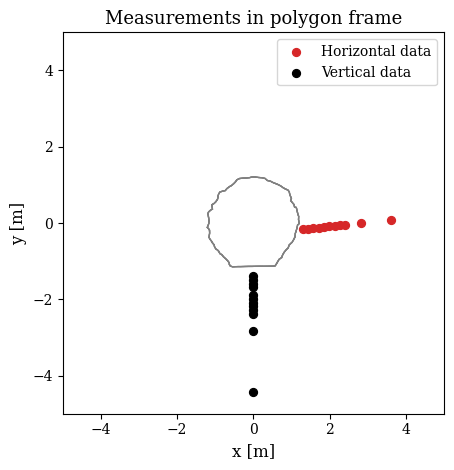

In [10]:
# Measurement depths [m] and permeabilities [m^2]
h_depths = np.array([0.17, 0.31, 0.45, 0.59, 0.73, 0.87, 1.01, 1.15, 1.29, 1.7, 2.5], dtype=float)
h_perm = np.array(
    [
        5e-16,
        2e-16,
        2e-16,
        2e-14,
        5e-16,
        8e-13,
        3e-15,
        8e-16,
        4e-17,
        2e-20,
        5e-21,
    ],
    dtype=float,
)

v_depths = np.array([0.25, 0.35, 0.45, 0.55, 0.75, 0.85, 0.95, 1.05, 1.15, 1.25, 1.7, 3.3], dtype=float)
v_perm = np.array(
    [
        2e-17,
        8e-17,
        8e-17,
        8e-15,
        7e-15,
        4e-18,
        6e-18,
        2e-15,
        7e-16,
        9e-17,
        5e-17,
        8e-21,
    ],
    dtype=float,
)

measurement_profiles = {
    "horizontal": {"depths": h_depths, "perm": h_perm},
    "vertical": {"depths": v_depths, "perm": v_perm},
}

orig_points_vertical = np.array(
    [
        [-0.00590468, -1.28667847],
        [-0.00589718, -1.43667847],
        [-0.00589218, -1.53667847],
        [-0.00588718, -1.63667847],
        [-0.00588218, -1.73667847],
        [-0.00587718, -1.83667847],
        [-0.00587218, -1.93667847],
        [-0.00586718, -2.03667847],
        [-0.00586218, -2.13667847],
        [-0.00585718, -2.23667847],
        [-0.00585218, -2.33667847],
        [-0.00584718, -2.43667847],
        [-0.00584218, -2.53667847],
        [-0.00582368, -2.87667847],
        [-0.00578568, -3.65667847],
        [-0.00574768, -4.43667847],
        [-0.00554868, -6.63667847],
        [-0.00554868, -6.63667847],
    ],
    dtype=float,
)

orig_points_horizontal = np.array(
    [
        [1.27414102, -0.16903214],
        [1.4231649, -0.15245487],
        [1.52251415, -0.14140337],
        [1.6218634, -0.13035186],
        [1.72121265, -0.11930035],
        [1.8205619, -0.10824884],
        [1.91991115, -0.09719733],
        [2.0192604, -0.08614582],
        [2.11860965, -0.07509431],
        [2.2179589, -0.0640428],
        [2.31730815, -0.05299129],
        [2.4166574, -0.04193978],
        [2.51600665, -0.03088827],
        [2.96220271, 0.01841753],
        [3.75690169, 0.10680927],
        [4.55160067, 0.19520102],
        [6.73710863, 0.4383037],
        [5.29653465, 0.27805686],
    ],
    dtype=float,
)

p_vert = np.array([-0.00591218, -1.13667847], dtype=float)
p_horiz = np.array([1.12506055, -0.18561569], dtype=float)

# Direction vectors (unit) from the niche boundary into the host rock
d_vert_unit = orig_points_vertical.mean(axis=0) - p_vert
d_vert_unit /= np.linalg.norm(d_vert_unit)

d_horiz_unit = orig_points_horizontal.mean(axis=0) - p_horiz
d_horiz_unit /= np.linalg.norm(d_horiz_unit)

h_coords = p_horiz + np.outer(h_depths, d_horiz_unit)
v_coords = p_vert + np.outer(v_depths, d_vert_unit)

measurement_points_polygon = np.vstack([h_coords, v_coords])
log_perm_obs = np.log(np.concatenate([h_perm, v_perm]))
n_h = h_perm.size
n_v = v_perm.size
color_horizontal = "tab:red"
color_vertical = "k"

# Ghost measurements along the square boundary
ghost_per_side = 10
square_min, square_max = -5.0, 5.0
ghost_axis = np.linspace(square_min, square_max, ghost_per_side)
ghost_points = np.vstack(
    [
        np.column_stack((np.full(ghost_per_side, square_min), ghost_axis)),
        np.column_stack((np.full(ghost_per_side, square_max), ghost_axis)),
        np.column_stack((ghost_axis, np.full(ghost_per_side, square_min))),
        np.column_stack((ghost_axis, np.full(ghost_per_side, square_max))),
    ]
)
ghost_log_mean = np.log(1e-21)
ghost_log_std = 1.0
ghost_rng = np.random.default_rng(7)
ghost_log_perm = ghost_rng.normal(loc=ghost_log_mean, scale=ghost_log_std, size=ghost_points.shape[0])
n_ghost = ghost_log_perm.size

measurement_points_all = np.vstack([measurement_points_polygon, ghost_points])
log_perm_all = np.concatenate([log_perm_obs, ghost_log_perm])
n_meas_all = measurement_points_all.shape[0]

niche_segments = load_niche_segments("cd-a_niche4.vtu")
boundary_points = segments_to_unique_points(niche_segments)
_, boundary_sorted = sort_points_by_angle(boundary_points)

def add_niche_patch(ax, facecolor="w", edgecolor="lightgray", zorder=3, alpha=1.0):
    patch = Polygon(boundary_sorted, closed=True, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha)
    ax.add_patch(patch)
    return patch

fig, ax = plt.subplots(figsize=(6.5, 4.8))
add_niche_patch(ax, facecolor="w", edgecolor="lightgray", alpha=0.85, zorder=1)
ax.scatter(h_coords[:, 0], h_coords[:, 1], s=32, c=color_horizontal, label="Horizontal data", zorder=4)
ax.scatter(v_coords[:, 0], v_coords[:, 1], s=32, c=color_vertical, label="Vertical data", zorder=4)
plot_segments(ax, niche_segments, color="gray", linewidth=0.9, zorder=5)
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_aspect("equal", "box")
ax.set_xlim(-5.0, 5.0)
ax.set_ylim(-5.0, 5.0)
ax.set_title("Measurements in polygon frame")
ax.legend()
plt.tight_layout()


In [11]:
class SquareExponentialField:
    """Load and evaluate a truncated squared exponential decomposition."""

    def __init__(self, mean, eigenvalues, eigenvectors, grid_x, grid_y):
        self.mean = float(mean)
        self.eigenvalues = np.asarray(eigenvalues, dtype=float)
        self.sqrt_eigenvalues = np.sqrt(self.eigenvalues)
        self.eigenvectors = np.asarray(eigenvectors, dtype=float)
        self.grid_x = np.asarray(grid_x, dtype=float)
        self.grid_y = np.asarray(grid_y, dtype=float)
        self.grid_shape = (len(self.grid_x), len(self.grid_y))

    @classmethod
    def from_hdf5(cls, path):
        with h5py.File(path, "r") as f:
            mean = f.attrs["mean"]
            eigenvalues = f["eigenvalues"][:]
            eigenvectors = f["eigenvectors"][:]
            grid_x = f["grid_x"][:]
            grid_y = f["grid_y"][:]
        return cls(mean=mean, eigenvalues=eigenvalues, eigenvectors=eigenvectors, grid_x=grid_x, grid_y=grid_y)

    def evaluate(self, coefficients=None):
        if coefficients is None:
            coefficients = np.zeros((self.eigenvectors.shape[0],), dtype=float)
        coeffs = np.asarray(coefficients, dtype=float)

        single_input = coeffs.ndim == 1
        if single_input:
            coeffs = coeffs[None, :]

        if coeffs.shape[1] != self.eigenvectors.shape[0]:
            raise ValueError("Coefficient dimension does not match number of modes")

        weighted_modes = coeffs * self.sqrt_eigenvalues[None, :]
        fields = weighted_modes @ self.eigenvectors
        fields = fields + self.mean

        if single_input:
            return fields.reshape(self.grid_shape)
        return fields.reshape((-1, *self.grid_shape))

    def sample(self, n_samples=1, rng=None):
        rng = np.random.default_rng(rng)
        coeffs = rng.standard_normal(size=(n_samples, self.eigenvectors.shape[0]))
        return self.evaluate(coeffs)

In [12]:
def smooth_curve(depths, values, n=600, dmin=0.0, dmax=3.5):
    depths = np.asarray(depths, dtype=float)
    values = np.asarray(values, dtype=float)
    grid = np.linspace(dmin, dmax, int(n))
    log_vals = np.interp(grid, depths, np.log(values))
    return grid, np.exp(log_vals)

In [13]:
rng = np.random.default_rng(2026)

field = SquareExponentialField.from_hdf5("square_exponential_decomposition.h5")
n_modes = field.eigenvalues.size
grid_extent = (
    float(field.grid_x.min()),
    float(field.grid_x.max()),
    float(field.grid_y.min()),
    float(field.grid_y.max()),
)
print(f"Loaded {n_modes} KL modes on grid {field.grid_shape} with mean {field.mean}")

phi_modes_grid = field.eigenvectors.reshape(n_modes, *field.grid_shape)
values = np.moveaxis(phi_modes_grid, 0, -1)
interpolator = RegularGridInterpolator(
    (field.grid_x, field.grid_y), values, bounds_error=False, fill_value=np.nan
)
phi_meas = interpolator(measurement_points_all)
if np.isnan(phi_meas).any():
    raise RuntimeError("Some measurement points fell outside the square grid")

design_matrix = phi_meas * field.sqrt_eigenvalues[None, :]

obs_noise_sigma = 2.0
noise_sigma_data = np.full(n_h + n_v, obs_noise_sigma)
ghost_noise_sigma = np.full(n_ghost, 2.0)
noise_sigma_all = np.concatenate([noise_sigma_data, ghost_noise_sigma])

w_diag = 1.0 / (noise_sigma_all ** 2)

mu_logk_prior = np.log(1e-14)
sigma_logk_prior = 3.0
delta_prior_mean = mu_logk_prior - field.mean

design_aug = np.hstack([design_matrix, np.ones((n_meas_all, 1))])
prior_precision = np.diag(np.concatenate([np.ones(n_modes), [1.0 / sigma_logk_prior**2]]))
prior_mean = np.concatenate([np.zeros(n_modes), [delta_prior_mean]])

precision = prior_precision + design_aug.T @ (design_aug * w_diag[:, None])
rhs = prior_precision @ prior_mean + design_aug.T @ ((log_perm_all - field.mean) * w_diag)

cho = cho_factor(precision, lower=True, check_finite=False)
theta_lin_map = cho_solve(cho, rhs, check_finite=False)

inv_prec = cho_solve(cho, np.eye(theta_lin_map.size), check_finite=False)
cov_diag = np.diag(inv_prec)
proposal_std = 0.25 * np.sqrt(np.maximum(cov_diag, 1e-10))

def log_prior(theta_vec):
    xi = theta_vec[:-1]
    delta = theta_vec[-1]
    lp = -0.5 * np.dot(xi, xi)
    lp += -0.5 * ((delta - delta_prior_mean) / sigma_logk_prior) ** 2
    return lp

def log_likelihood(theta_vec):
    xi = theta_vec[:-1]
    delta = theta_vec[-1]
    pred = field.mean + delta + design_matrix @ xi
    resid = log_perm_all - pred
    return -0.5 * np.sum((resid / noise_sigma_all) ** 2)

def log_posterior(theta_vec):
    return log_prior(theta_vec) + log_likelihood(theta_vec)

def metropolis_hastings(log_post, theta_init, n_samples, proposal_std, burnin=0, thinning=1, rng=None):
    theta_curr = np.asarray(theta_init, dtype=float)
    dim = theta_curr.size
    rng = np.random.default_rng(rng)

    prop_std = np.asarray(proposal_std, dtype=float)
    total_steps = burnin + n_samples * thinning

    samples = np.zeros((n_samples, dim))
    log_posts = np.zeros(n_samples)
    logp_curr = log_post(theta_curr)
    accepts = 0
    kept = 0

    for step in range(total_steps):
        proposal = theta_curr + prop_std * rng.standard_normal(size=dim)
        logp_prop = log_post(proposal)

        if np.log(rng.uniform()) < (logp_prop - logp_curr):
            theta_curr = proposal
            logp_curr = logp_prop
            accepts += 1

        if step >= burnin and (step - burnin) % thinning == 0:
            samples[kept, :] = theta_curr
            log_posts[kept] = logp_curr
            kept += 1

    acc_rate = accepts / float(total_steps)
    return samples, log_posts, acc_rate


theta_init = theta_lin_map
n_samples = 350000
burnin = 2000
thinning = 2
samples, log_posts, acc_rate = metropolis_hastings(
    log_post=log_posterior,
    theta_init=theta_init,
    n_samples=n_samples,
    proposal_std=proposal_std,
    burnin=burnin,
    thinning=thinning,
    rng=rng,
)

map_idx = int(np.argmax(log_posts))
theta_map = samples[map_idx]
xi_map = theta_map[:-1]
delta_map = float(theta_map[-1])

xi_samples = samples[:, :-1]
delta_samples = samples[:, -1]

log_pred_map = field.mean + delta_map + design_matrix @ xi_map
perm_pred_map = np.exp(log_pred_map)

log_pred_samples = field.mean + delta_samples[:, None] + xi_samples @ design_matrix.T
perm_pred_samples = np.exp(log_pred_samples)

h_low, h_med, h_high = np.percentile(perm_pred_samples[:, :n_h], [5, 50, 95], axis=0)
v_slice = perm_pred_samples[:, n_h : n_h + n_v]
v_low, v_med, v_high = np.percentile(v_slice, [5, 50, 95], axis=0)

print(f"Acceptance rate: {acc_rate:.3f}")
print(f"MAP background shift (delta): {delta_map:.2f} -> implied background log k ~ {field.mean + delta_map:.2f}")

log_field_map = field.evaluate(coefficients=xi_map) + delta_map
log_floor_vis = np.log(1e-21)
log_ceiling_vis = np.log(1e-12)
log_field_map = np.clip(log_field_map, log_floor_vis, log_ceiling_vis)
vmin, vmax = log_floor_vis, log_ceiling_vis


Loaded 152 KL modes on grid (101, 101) with mean -41.0
Acceptance rate: 0.034
MAP background shift (delta): -5.16 -> implied background log k ~ -46.16


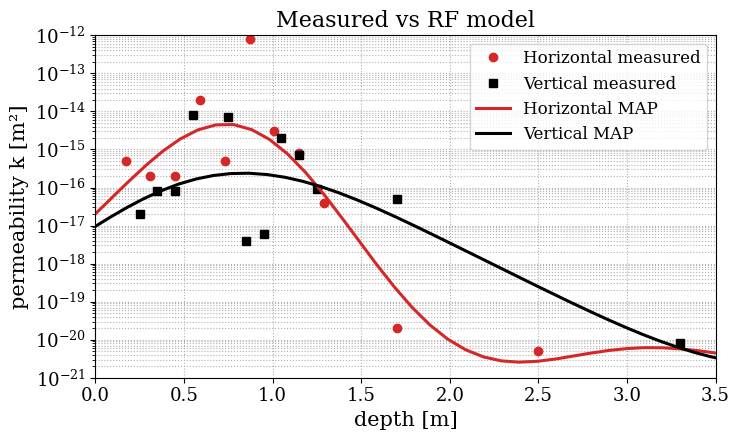

In [14]:

depth_line = np.linspace(0.0, 3.5, 600)
coords_h_line = p_horiz + np.outer(depth_line, d_horiz_unit)
coords_v_line = p_vert + np.outer(depth_line, d_vert_unit)
interp_map = RegularGridInterpolator((field.grid_x, field.grid_y), log_field_map, bounds_error=False, fill_value=np.nan)
log_h_line_map = interp_map(coords_h_line)
log_v_line_map = interp_map(coords_v_line)

fig, ax = plt.subplots(figsize=(7.5, 4.5))
ax.semilogy(h_depths, h_perm, "o", color=color_horizontal, label="Horizontal measured")
ax.semilogy(v_depths, v_perm, "s", color=color_vertical, label="Vertical measured")
ax.semilogy(depth_line, np.exp(log_h_line_map), "-", color=color_horizontal, linewidth=2.2, label="Horizontal MAP")
ax.semilogy(depth_line, np.exp(log_v_line_map), "-", color=color_vertical, linewidth=2.2, label="Vertical MAP")

ax.set_xlim(0.0, 3.5)
ax.set_ylim(1e-21, 1e-12)
ax.set_xlabel("depth [m]", fontsize=15)
ax.set_ylabel("permeability k [m²]", fontsize=15)
ax.set_title("Measured vs RF model", fontsize=16)
ax.tick_params(labelsize=13)
ax.grid(True, which="both", linestyle=":", linewidth=0.8)
ax.legend(fontsize=12)

plt.tight_layout()


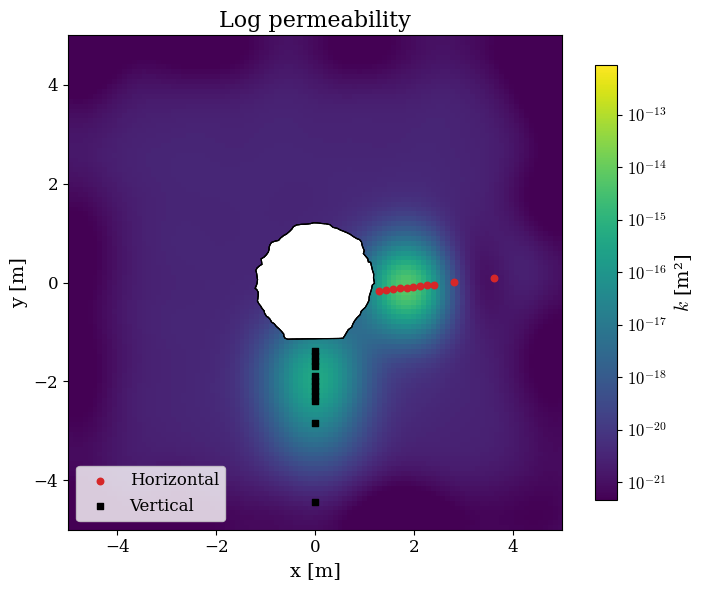

In [15]:
def log10_formatter(val, pos):
    exp10 = val / np.log(10.0)
    return rf"$10^{{{exp10:.0f}}}$"


fig, ax = plt.subplots(figsize=(7.5, 6.0))
pm = ax.imshow(
    log_field_map.T,
    origin="lower",
    extent=(grid_extent[0], grid_extent[1], grid_extent[2], grid_extent[3]),
    vmin=vmin,
    vmax=vmax,
    cmap="viridis",
    aspect="equal",
)
add_niche_patch(ax, facecolor="w", edgecolor="none", zorder=3)
plot_segments(ax, niche_segments, color="k", linewidth=0.8, zorder=4)
ax.scatter(h_coords[:, 0], h_coords[:, 1], s=22, color=color_horizontal, marker="o", label="Horizontal", zorder=5)
ax.scatter(v_coords[:, 0], v_coords[:, 1], s=22, color=color_vertical, marker="s", label="Vertical", zorder=5)

ax.set_xlim(-5.0, 5.0)
ax.set_ylim(-5.0, 5.0)
ax.set_title("Log permeability", fontsize=16)
ax.set_xlabel("x [m]", fontsize=14)
ax.set_ylabel("y [m]", fontsize=14)
ax.tick_params(labelsize=12)
ax.legend(loc="lower left", fontsize=12)

cbar = fig.colorbar(pm, ax=ax, shrink=0.88)
cbar.set_label(r"$k$ [m²]", fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.formatter = FuncFormatter(log10_formatter)
cbar.update_ticks()

plt.tight_layout()


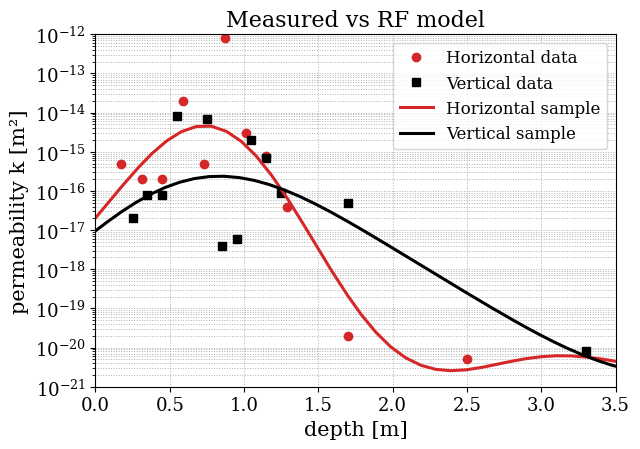

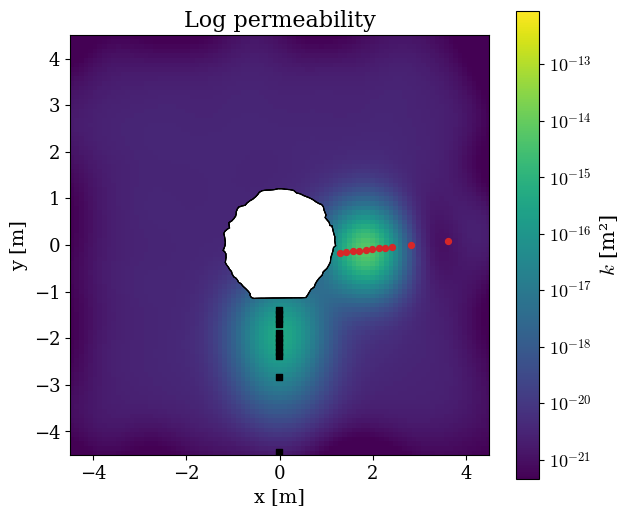

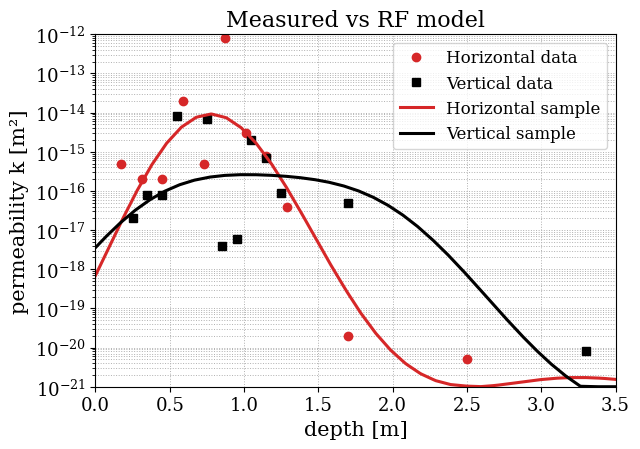

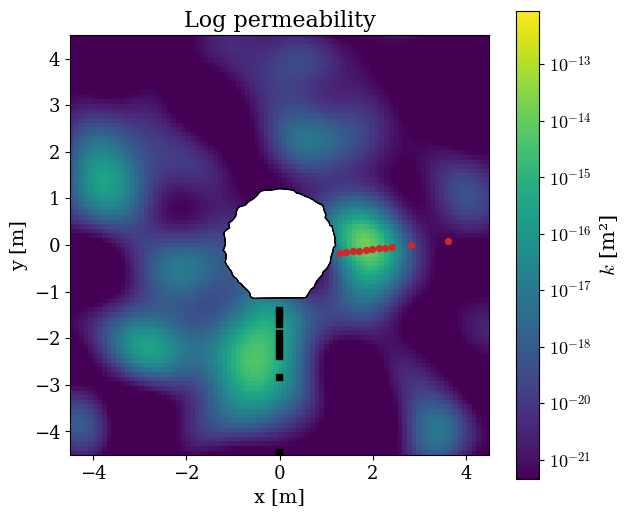

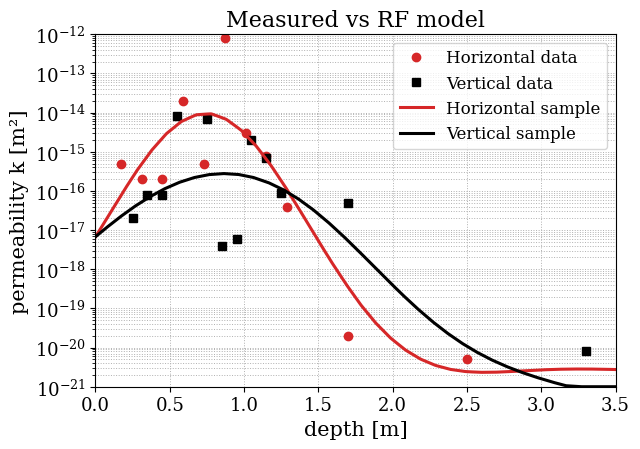

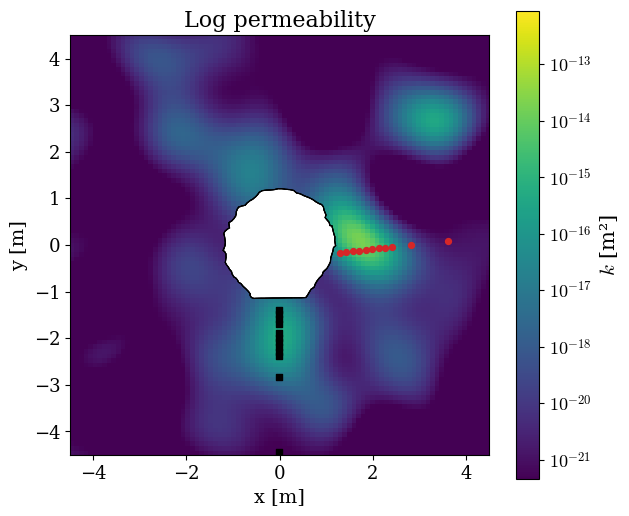

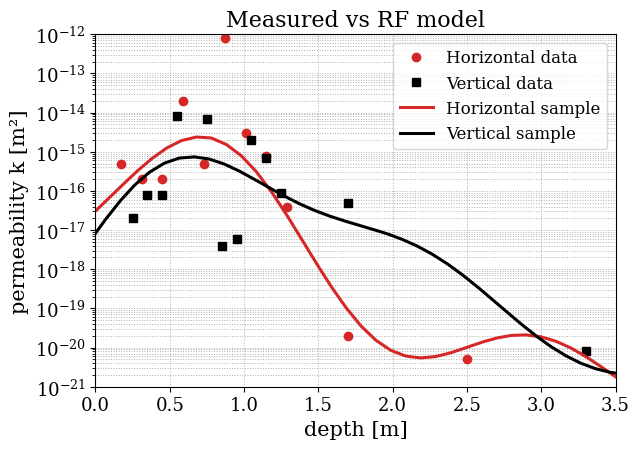

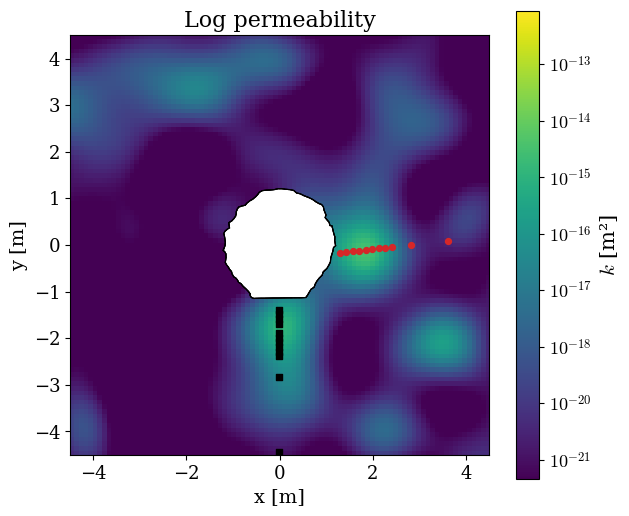

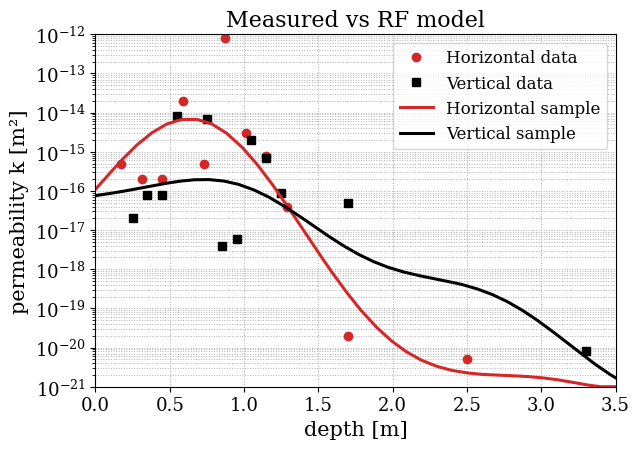

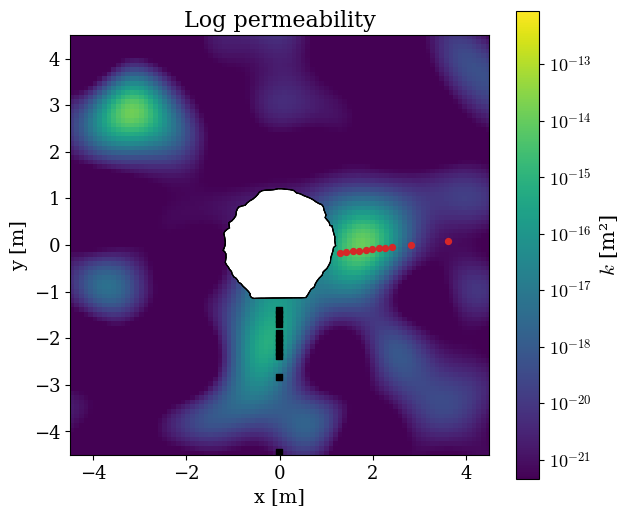

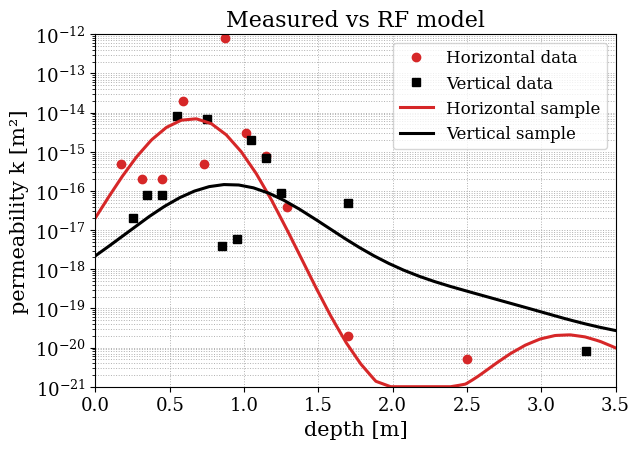

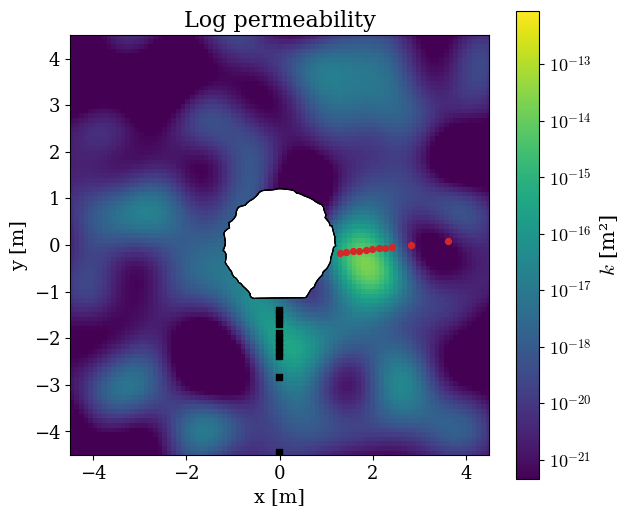

In [16]:

# Posterior samples mirroring the circular notebook layout (separate figures per sample)
depth_line = np.linspace(0.0, 3.5, 600)
coords_h_line = p_horiz + np.outer(depth_line, d_horiz_unit)
coords_v_line = p_vert + np.outer(depth_line, d_vert_unit)

n_show = 6
idx_show = np.linspace(0, xi_samples.shape[0] - 1, n_show, dtype=int)

for j, idx in enumerate(idx_show, start=1):
    coeffs = xi_samples[idx]
    delta_s = float(delta_samples[idx])
    perm_pred_s = np.exp(field.mean + delta_s + design_matrix @ coeffs)
    log_field_s = field.evaluate(coefficients=coeffs) + delta_s
    log_field_s = np.clip(log_field_s, log_floor_vis, log_ceiling_vis)

    interp_s = RegularGridInterpolator((field.grid_x, field.grid_y), log_field_s, bounds_error=False, fill_value=np.nan)
    log_h_line_s = interp_s(coords_h_line)
    log_v_line_s = interp_s(coords_v_line)
    h_grid_s, h_line_s = depth_line, np.exp(log_h_line_s)
    v_grid_s, v_line_s = depth_line, np.exp(log_v_line_s)

    fig_fit, ax_fit = plt.subplots(figsize=(6.5, 4.6))
    ax_fit.semilogy(h_depths, h_perm, "o", color=color_horizontal, label="Horizontal data")
    ax_fit.semilogy(v_depths, v_perm, "s", color=color_vertical, label="Vertical data")
    ax_fit.semilogy(h_grid_s, h_line_s, "-", color=color_horizontal, linewidth=2.2, label="Horizontal sample")
    ax_fit.semilogy(v_grid_s, v_line_s, "-", color=color_vertical, linewidth=2.2, label="Vertical sample")
    ax_fit.set_xlim(0.0, 3.5)
    ax_fit.set_ylim(1e-21, 1e-12)
    ax_fit.set_xlabel("depth [m]", fontsize=15)
    ax_fit.set_ylabel("permeability k [m²]", fontsize=15)
    ax_fit.set_title("Measured vs RF model", fontsize=16)
    ax_fit.grid(True, which="both", linestyle=":", linewidth=0.7)
    ax_fit.tick_params(labelsize=13)
    ax_fit.legend(fontsize=12)
    fig_fit.tight_layout()

    fig_field, ax_field = plt.subplots(figsize=(6.4, 6.0))
    pcm = ax_field.imshow(
        log_field_s.T,
        origin="lower",
        extent=(grid_extent[0], grid_extent[1], grid_extent[2], grid_extent[3]),
        vmin=vmin,
        vmax=vmax,
        cmap="viridis",
        aspect="equal",
    )
    add_niche_patch(ax_field, facecolor="w", edgecolor="none", zorder=3)
    plot_segments(ax_field, niche_segments, color="k", linewidth=0.8, zorder=4)
    ax_field.scatter(h_coords[:, 0], h_coords[:, 1], s=18, color=color_horizontal, marker="o", zorder=5)
    ax_field.scatter(v_coords[:, 0], v_coords[:, 1], s=18, color=color_vertical, marker="s", zorder=5)
    ax_field.set_xlim(-4.5, 4.5)
    ax_field.set_ylim(-4.5, 4.5)
    ax_field.set_title("Log permeability", fontsize=16)
    ax_field.set_xlabel("x [m]", fontsize=14)
    ax_field.set_ylabel("y [m]", fontsize=14)
    ax_field.tick_params(labelsize=13)

    cbar = fig_field.colorbar(pcm, ax=ax_field, shrink=0.85)
    cbar.set_label(r"$k$ [m²]", fontsize=15)
    cbar.ax.tick_params(labelsize=13)
    cbar.formatter = FuncFormatter(log10_formatter)
    cbar.update_ticks()
    fig_field.tight_layout()
